In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [83]:
path = 'data/data.csv'
df = pd.read_csv(path, encoding='ISO-8859-1') # Using a different encoding while info is fixed

In [84]:
df.sample(5)

,Authors,Year,Paper,Country,MDS,Data Source Primary,Data Source Secondary,Algorithm,Task,Cross Validation,Performance Metric,Sample Size,Dataset,Goal,Abstract,Person,Notes
132,Rahman et al.,2023.0,Auto-Gait: Automatic Ataxia Risk Assessment wi...,USA,Ataxia (SCA),Gait,Gait Video Recordings,"FasterRCNN, RF, Yolo",10-meter walk task for SARA evaluation,10-Fold,"Accuracy, F1-score, MAE, Pearson's correlation","89 participants (65 SCA, 24 HC)",Own Recruitment,Develop a computer vision-based tool using mac...,"Many patients with neurological disorders, suc...",IC,NaN
73,El Maachi et al.,2020.0,Deep 1D-Convnet for accurate Parkinson disease...,Canada,PD,NaN,VGRF,1D-Convolutional Neural Networks,Gait analysis during a flat surface walk,10-fold,"Accuracy, Sensitivity, Specificity, F1-score","93 PD, 73 healthy",PhysioNet Gait in Parkinson's Disease database,Creating a deep learning-based method for dete...,Diagnosing Parkinson's disease is a complex ta...,IC,NaN
152,Setiawan et al.,2021.0,Implementation of a Deep Learning Algorithm Ba...,Taiwan,PD,NaN,Vertical Ground Reaction Force (vGRF) signals,CNN,Gait analysis involving foot force signals dur...,10-fold,"Accuracy, Sensitivity, Specificity, AUC","93 PD, 73 healthy",PhysioNet Gait in Parkinson's Disease database,To develop a deep learning-based method for de...,Conventional approaches to diagnosing Parkinso...,IC,NaN
169,Teshuva et al.,2019.0,Using Wearables to Assess Bradykinesia and Rig...,Israel,Bradykinesia,NaN,"Wearable devices (accelerometers, gyroscopes, ...","PCA, SVM","Gait, arm swing, hand movements",NaN,NaN,NaN,NaN,NaN,NaN,IC,NaN
53,Loaiza Duque et al.,2020.0,Angular Velocity Analysis Boosted by Machine L...,"Columbia, Spain","ET, PD",NaN,Angular velocity signals from a smartphones b...,"SVM, KNN, LR, DT, NB, Ensemble",Rest and posture positions during tremor asses...,Data testing/training divisions,"Accuracy, Sensitivity, Specificity","51 Patients (19 Parkinson's Disease, 20 Essent...",Movement Disorders Unit of Hospital Clinic of ...,To develop machine learning models using smart...,Recent research has shown that smartphones/sma...,IC,NaN


In [85]:
# Converting Year to int. Filling NaN with 0
df['Year'] = df['Year'].fillna(0).astype(int)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Authors                223 non-null    object
 1   Year                   224 non-null    int64 
 2   Paper                  223 non-null    object
 3   Country                220 non-null    object
 4   MDS                    221 non-null    object
 5   Data Source Primary    6 non-null      object
 6   Data Source Secondary  221 non-null    object
 7   Algorithm              222 non-null    object
 8   Task                   187 non-null    object
 9   Cross Validation       170 non-null    object
 10  Performance Metric     200 non-null    object
 11  Sample Size            189 non-null    object
 12  Dataset                188 non-null    object
 13  Goal                   200 non-null    object
 14  Abstract               196 non-null    object
 15  Person                 

In [141]:
df[df['Country'] == 'US, Canada, UK']

,Authors,Year,Paper,Country,MDS,Data Source Primary,Data Source Secondary,Algorithm,Task,Cross Validation,Performance Metric,Sample Size,Dataset,Goal,Abstract,Person,Notes
115,Nielsen et al.,2020,Atypical Functional Connectivity in Tourette S...,"US, Canada, UK",TS,NaN,fMRI,"SVM, SVR",NaN,LOOCV,"Accuracy, Sensitvity, Specificity","101 TS, 101 Control",Own Recruitment,Investiage brain networks between TS and Contr...,BACKGROUND: Tourette syndrome (TS) is a neurop...,NC,NaN
133,Rajinikanth et al.,2023,A Novel System to Monitor Tic Attacks for Tour...,"US, Canada, UK",TS,NaN,"Wearables, Speech","LOF,Regression, RNN, LSTM, DNN",ADL,NaN,Accuracy,70 Patients,Sensor Data,Develop a wearable wristband with ML for tic a...,Background: Tourette syndrome is a neurologica...,NC,NaN


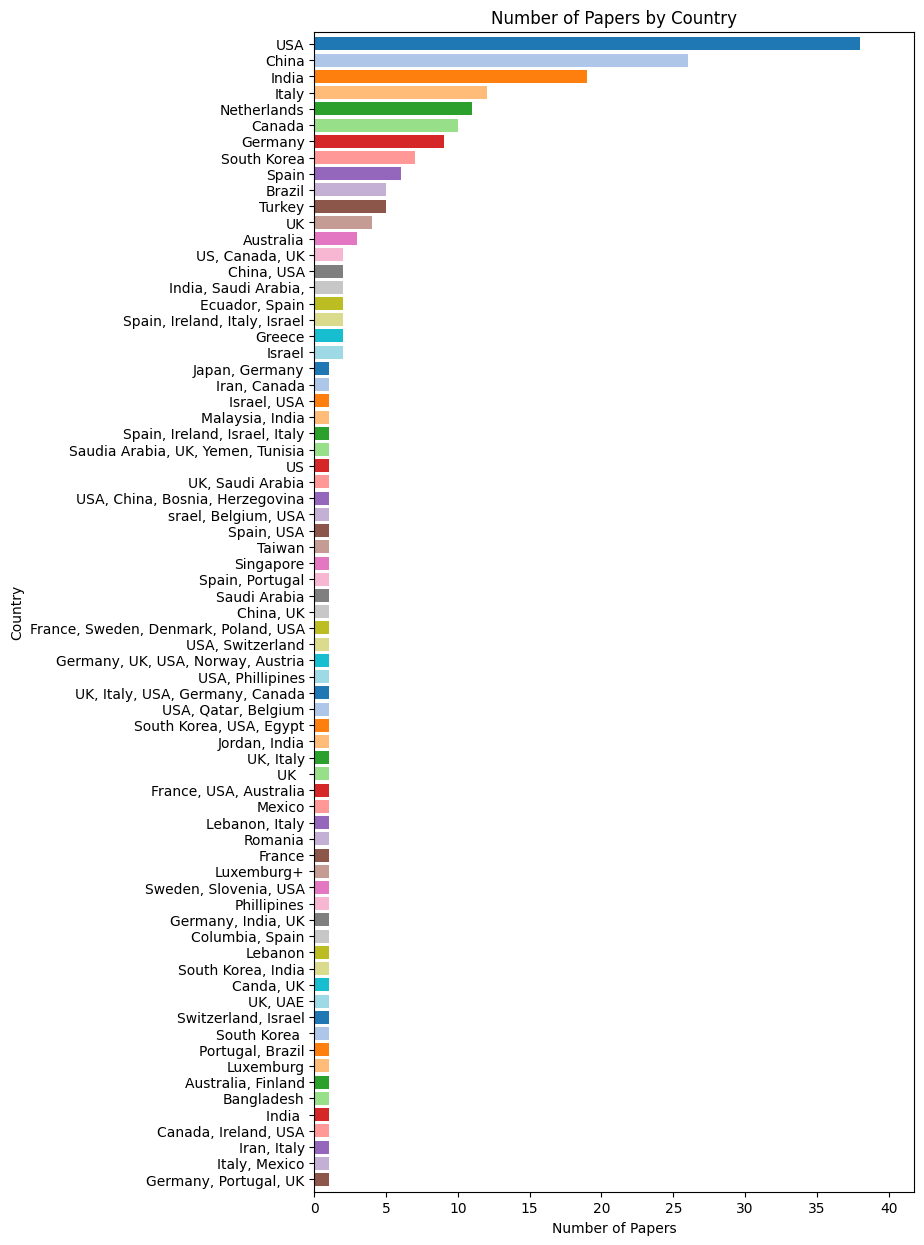

In [140]:
# Plot the horizontal bar graph with spacing between bars
country_counts = df['Country'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(country_counts.index, country_counts.values, color=cm.tab20.colors[:len(country_counts)])
# Set the x-axis label
max_count = country_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Country')
plt.title('Number of Papers by Country')

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

In [81]:
df['MDS'].value_counts()

PD                                                                          50
Freezing of Gait                                                            30
TS                                                                          26
Bradykinesia                                                                23
Dyskinesia                                                                  19
Dystonia                                                                     9
Dyskinesia, PD                                                               9
Isolated Dystonia                                                            5
Bradykinesia                                                                 5
Ataxia                                                                       4
Cervical Dystonia                                                            4
Ataxia (Multiple Sclerosis)                                                  3
PD                                                  

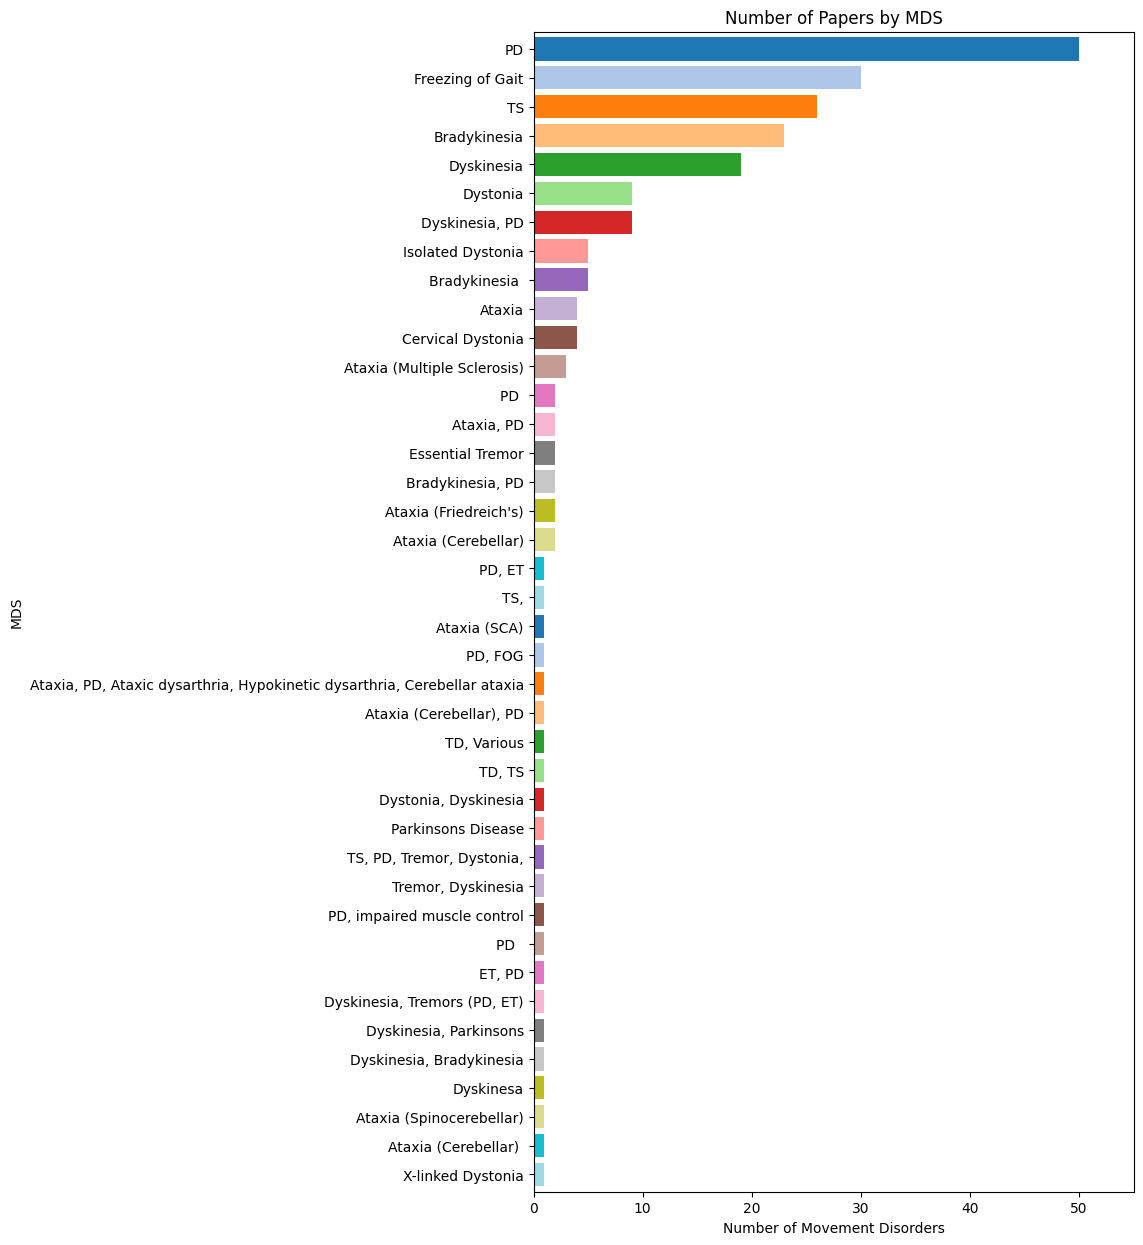

In [139]:
# Plot the horizontal bar graph with spacing between bars
mds_counts = df['MDS'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(mds_counts.index, mds_counts.values, color=cm.tab20.colors[:len(mds_counts)])
# Set the x-axis label
max_count = mds_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Movement Disorders')
plt.ylabel('MDS')
plt.title('Number of Papers by MDS')

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

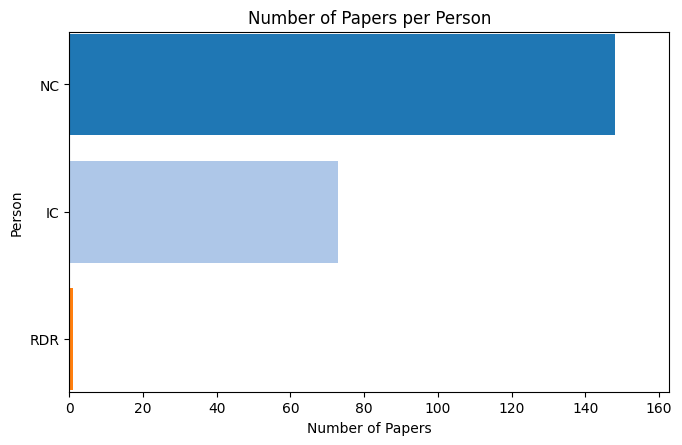

In [156]:
# Plot the horizontal bar graph with spacing between bars
person_counts = df['Person'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(person_counts.index, person_counts.values, color=cm.tab20.colors[:len(person_counts)])
# Set the x-axis label
max_count = person_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Person')
plt.title('Number of Papers per Person')

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=0.5, bottom=0.05)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()